# Cálculo del nivel de enfoque sobre zonas de una imagen

### Antonio Sanz 

En este notebook entreno un red convolucional sobre el dataset de imágenes cifar-10. Esta dataset contiene 50K imágenes, todas ellas con un nivel de contraste alto que consideraremos óptimo en este caso. Para poder entrenar nuestra red con imagenes desenfocadas y borrosas, he aplicado un filtro Gaussiano con diferentes tamaños de Kernel para obtener 6 enfoques diferentes sobre cada imagen. Los directorios de train y test tienen esta estructura:

- /train
 - /blur3
 - /blur9
 - /blur15
 - /focus
- /test
 - /blur3
 - /blur9
 - /blur15
 - /focus

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import subprocess
import os
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt
from keras import optimizers
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input

from keras.constraints import maxnorm
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model

%matplotlib inline

In [0]:
from google.colab import drive

drivedir = '/content/gdrive'

drive.mount(drivedir)

print('Google Drive mount completed')

#check correct mount of drive directory
!df -h

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Google Drive mount completed
Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   34G   32G  52% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
/dev/sda1        75G   35G   40G  47% /opt/bin
tmpfs           6.4G   16K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  5.8G  9.3G  39% /content/gdrive


In [0]:
! git clone https://github.com/antonio490/Autofocus.git

Cloning into 'Autofocus'...
remote: Enumerating objects: 980220, done.
remote: Total 980220 (delta 0), reused 0 (delta 0), pack-reused 980220
Receiving objects: 100% (980220/980220), 874.16 MiB | 24.12 MiB/s, done.
Resolving deltas: 100% (135/135), done.
Checking out files: 100% (310767/310767), done.


In [0]:
# DIRECTORIOS

DIR_GDRIVE = drivedir + '/My Drive/TFM/modelos/' 
DIR_GDRIVE_PLOTS = drivedir + '/My Drive/TFM/plots/' 


prac_dir = '/content/Autofocus/out/' # Dataset con 2 clases
#prac_dir = '/content/Autofocus/out_multiclass/' # Dataset con 4 clases


train_dir = prac_dir + 'train' # Directorio datos train
test_dir = prac_dir + 'test' # Directorio datos test

os.chdir(prac_dir) # Nos desplazamos al directorio padre

In [0]:
# HIPERPARAMETROS 

BATCH_SIZE = 64
IMAGE_RESIZE = 32

In [0]:
# AUMENTAMOS CONJUNTO DE DATOS DE ENTRENAMIENTO

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    )

test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_RESIZE,IMAGE_RESIZE),
        batch_size=BATCH_SIZE,
        #color_mode="grayscale",
        class_mode='categorical'
        )

validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_RESIZE,IMAGE_RESIZE),
        batch_size=BATCH_SIZE,
        #color_mode="grayscale",
        class_mode='categorical'
        )

Found 83828 images belonging to 2 classes.
Found 25558 images belonging to 2 classes.


In [0]:
# HIPERPARAMETROS 

L_RATE  = 0.01
EPOCHS = 30
TRAIN_SAMPLES = train_generator.n 
VAL_SAMPLES = validation_generator.n 
NUM_CLASSES = train_generator.num_classes

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VAL = validation_generator.n//validation_generator.batch_size

In [0]:
# CALLBACKS

if NUM_CLASSES <= 2:
	ACCURACY_THRESHOLD = 0.98
elif NUM_CLASSES > 2:
	ACCURACY_THRESHOLD = 0.96

class MinAccuracy(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') > ACCURACY_THRESHOLD and epoch > 15):
			print("\nSe ha alcanzado un precisión del %2.2f%% , paramos entrenamiento!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

# Stop training when a monitored quantity has stopped improving.
# patience: number of epochs that produced the monitored quantity with no improvement after which training will be stopped.

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1, min_delta=1e-4)  

# Reduce learning rate when a metric has stopped improving.
# This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4)  


# Instanciamos objeto MinAccuracy
min_accuracy = MinAccuracy()

callbacks_list = [reduce_lr, min_accuracy] #min_accuracy, early_stop, reduce_lr]

In [0]:
# ARQUITECTURA RED CONVOLUCIONAL

def Net():

  modelo = tf.keras.Sequential()
  modelo.add(tf.keras.layers.Convolution2D(10, 3, input_shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3), padding='same', strides=(1,1), activation='relu'))
  modelo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  modelo.add(tf.keras.layers.Convolution2D(30, 5, strides=(1,1), activation='relu'))
  modelo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  modelo.add(tf.keras.layers.Convolution2D(64, 4, strides=(1,1), activation='relu'))  
  modelo.add(tf.keras.layers.Dropout(0.8))

  modelo.add(tf.keras.layers.Flatten())
  modelo.add(tf.keras.layers.Dense(64, activation='relu')) 
  modelo.add(tf.keras.layers.Dense(2, activation='relu')) 

  modelo.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))

  modelo.summary()
  return modelo

In [0]:
modelo = Net()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 10)        280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 10)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 30)        7530      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 30)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          30784     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

In [0]:
# OPTIMIZADORES

#rms = tf.keras.optimizers.RMSprop(learning_rate=L_RATE, rho=0.9)
#adam = tf.keras.optimizers.Adam(learning_rate=L_RATE, beta_1=0.9, beta_2=0.999, amsgrad=False)
#adamax = tf.keras.optimizers.Adamax(lr=L_RATE, beta_1=0.9, beta_2=0.999)
sgd = tf.keras.optimizers.SGD(lr=L_RATE, decay=0.0005, momentum=0.9)

#modelo.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
modelo.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [0]:
# ENTRENAMIENTO MODELO 

m = modelo.fit(
          train_generator,
          steps_per_epoch = STEP_SIZE_TRAIN, 
          epochs = EPOCHS,
          validation_data = validation_generator,
          callbacks = callbacks_list,
          validation_steps = STEP_SIZE_VAL
          )

Epoch 1/30
1309/1309 [==============================] - 38s 29ms/step - loss: 0.5218 - accuracy: 0.7012 - val_loss: 0.4347 - val_accuracy: 0.8553 - lr: 0.0100
Epoch 2/30
1309/1309 [==============================] - 37s 28ms/step - loss: 0.2388 - accuracy: 0.9105 - val_loss: 0.3735 - val_accuracy: 0.9062 - lr: 0.0100
Epoch 3/30
1309/1309 [==============================] - 36s 28ms/step - loss: 0.1555 - accuracy: 0.9484 - val_loss: 0.2606 - val_accuracy: 0.9447 - lr: 0.0100
Epoch 4/30
1309/1309 [==============================] - 37s 28ms/step - loss: 0.1209 - accuracy: 0.9607 - val_loss: 0.2128 - val_accuracy: 0.9498 - lr: 0.0100
Epoch 5/30
1309/1309 [==============================] - 37s 28ms/step - loss: 0.1016 - accuracy: 0.9672 - val_loss: 0.2290 - val_accuracy: 0.9491 - lr: 0.0100
Epoch 6/30
1309/1309 [==============================] - 37s 28ms/step - loss: 0.0855 - accuracy: 0.9732 - val_loss: 0.2615 - val_accuracy: 0.9339 - lr: 0.0100
Epoch 7/30
1309/1309 [========================

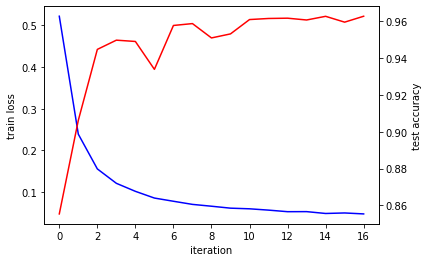

In [0]:
# VISUALIZACIONES

from pylab import *
%matplotlib inline

_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(m.history['loss'], 'b')
ax2.plot(m.history['val_accuracy'], 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_xlabel('Test accuracy: {:.2f}'.format(m.history['val_accuracy'][-1]))

plt.savefig(DIR_GDRIVE_PLOTS + "modelo_" + str(NUM_CLASSES) + "_" + str(EPOCHS) + "_Net_1.png")

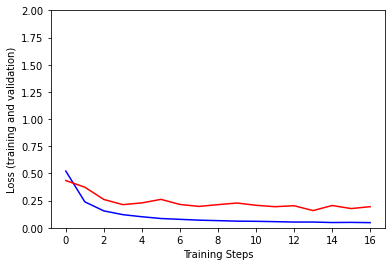

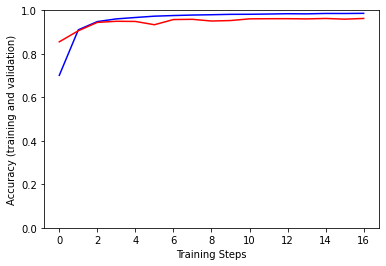

In [0]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(m.history["loss"], 'b')
plt.plot(m.history["val_loss"], 'r')

plt.savefig(DIR_GDRIVE_PLOTS + "modelo_" + str(NUM_CLASSES) + "_" + str(EPOCHS) + "_Net_2.png")

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(m.history["accuracy"], 'b')
plt.plot(m.history["val_accuracy"], 'r')

plt.savefig(DIR_GDRIVE_PLOTS + "modelo_" + str(NUM_CLASSES) + "_" + str(EPOCHS) + "_Net_3.png")

In [0]:
# ALMACENAMOS LOS PESOS DE NUESTRO MODELO ENTRENADO

modelo.save(DIR_GDRIVE + "modelo_" + str(NUM_CLASSES) + "_" + str(EPOCHS) + "_Net") 
print("Saved model to disk")

modelo.save_weights(DIR_GDRIVE + "modelo_" + str(NUM_CLASSES) + "_" + str(EPOCHS) + "_Net_weights.h5")
print("Saved model weights to disk")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/TFM/modelos/modelo_2_30_Net/assets
Saved model to disk
Saved model weights to disk


In [0]:
def load_trained_model(path, flag):

  if flag:
    m = pNet()
    m.load_weights(path + "_weights.h5")
  else:
    m = tf.keras.models.load_model(path)
  return m

In [0]:
# VISUALIZACION SECCIONES IMAGENES 32x32

def showGridImage(img_array):
  plt.figure(figsize=(8,8))
  plt.subplots_adjust(hspace=0.2)
  for n in range(sub_images**2):
    plt.subplot(sub_images, sub_images, n+1)
    plt.imshow(img_array[n], cmap="gray")
    plt.axis('off')

In [0]:
# VISUALIZACION PREDICCION IMAGENES 32x32

def predictBlur(modelo, img_array):
  testGEN.reset()
  predictions = modelo.predict(testGEN, steps=testGEN.n//testGEN.batch_size, verbose=1)
  image_batch = next(testGEN)

  plt.figure(figsize=(5,5))
  plt.subplots_adjust(hspace=0.3)

  for k in range(sub_images**2):
    image = image_batch[k]
    pred = predictions[k]
    the_pred = np.argmax(pred)
    predicted = class_names[the_pred]
    plt.subplot(sub_images, sub_images, k+1)
    plt.imshow(img_array[k], cmap="gray")
    color = "green" if predicted == "Focus" else "red"
    plt.title(predicted.title(), color=color)
    plt.axis('off')
    plt.savefig(DIR_GDRIVE_PLOTS + "model_predict_" + str(sub_images) + ".png")

In [0]:
#m = load_trained_model(DIR_GDRIVE + "modelo_" + str(BATCH_SIZE) + "_" + str(EPOCHS) + "_Net", False)

In [0]:
class_names = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(class_names)

['Blur' 'Focus']


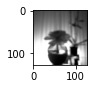

In [0]:

SIZE = 128

#img = cv.imread(DIR_GDRIVE + "photos/IMG_1591717005.png") # Blur
#img = cv.imread(DIR_GDRIVE + "photos/IMG_1591716996.png") # Focus

#img = cv.imread(DIR_GDRIVE + "photos/IMG_1591717516.png") # Blur

# 128
img = cv.imread(DIR_GDRIVE + "photos/IMG_1591718605.png") # Blur
#img = cv.imread(DIR_GDRIVE + "photos/IMG_1591718593.png") # Focus


#img = cv.resize(img, (SIZE, SIZE), interpolation = cv.INTER_AREA)
figure(figsize=(1,1)) 
plt.imshow(img, cmap='gray');

In [0]:
# CROP IMAGE 
x = y = 0
h = w = IMAGE_RESIZE
img_array = []
sub_images = int(img.shape[0] / IMAGE_RESIZE)
print("Número de divisiones en la imagen: ", sub_images**2)

for j in range(sub_images):
  for z in range (sub_images):
    x = IMAGE_RESIZE * z 
    y = IMAGE_RESIZE * j
    img_crop = img[y:y+h, x:x+w]
    img_array.append(img_crop)

Número de divisiones en la imagen:  16


In [0]:
showGridImage(img_array)

In [0]:
# ALMACENAMOS LA IMAGEN EN GDRIVE
index=0

for im in img_array:
  path = DIR_GDRIVE + 'imagen/test/' + str(index) + '.png'
  print(path)
  cv.imwrite(path, im)
  index += 1

/content/gdrive/My Drive/TFM/modelos/imagen/test/0.png
/content/gdrive/My Drive/TFM/modelos/imagen/test/1.png
/content/gdrive/My Drive/TFM/modelos/imagen/test/2.png
/content/gdrive/My Drive/TFM/modelos/imagen/test/3.png
/content/gdrive/My Drive/TFM/modelos/imagen/test/4.png
/content/gdrive/My Drive/TFM/modelos/imagen/test/5.png
/content/gdrive/My Drive/TFM/modelos/imagen/test/6.png
/content/gdrive/My Drive/TFM/modelos/imagen/test/7.png
/content/gdrive/My Drive/TFM/modelos/imagen/test/8.png
/content/gdrive/My Drive/TFM/modelos/imagen/test/9.png
/content/gdrive/My Drive/TFM/modelos/imagen/test/10.png
/content/gdrive/My Drive/TFM/modelos/imagen/test/11.png
/content/gdrive/My Drive/TFM/modelos/imagen/test/12.png
/content/gdrive/My Drive/TFM/modelos/imagen/test/13.png
/content/gdrive/My Drive/TFM/modelos/imagen/test/14.png
/content/gdrive/My Drive/TFM/modelos/imagen/test/15.png


In [0]:
imageGenerator = ImageDataGenerator()
path = DIR_GDRIVE + 'imagen/'

batch_size = sub_images**2

testGEN = imageGenerator.flow_from_directory(
          directory= path,
          target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
          batch_size=batch_size,
          class_mode=None
      );

Found 16 images belonging to 1 classes.


1/1 [==============================] - 0s 1ms/step


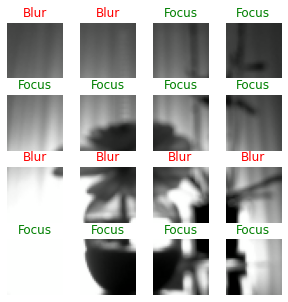

In [0]:
# PREDICCION
predictBlur(modelo, img_array)

In [0]:
#keras_model = tf.keras.models.load_model(DIR_GDRIVE + "modelo_32x3pNET")

In [0]:
# Convert model to tensorflowLite

converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tf_lite_model = converter.convert()
open(DIR_GDRIVE + "modeloLite_32xpNet", "wb").write(tf_lite_model)